# 4. Volatility Clustering Analysis

This notebook analyzes volatility clustering patterns in NVDA data, including:
- Rolling volatility calculation
- High volatility period identification
- Volatility persistence analysis
- Autocorrelation of squared returns
- GARCH-like behavior detection


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the cleaned data
all_data = pd.read_csv('combined_nvda_ohlc_clean.csv')
all_data['date'] = pd.to_datetime(all_data['date'])
all_data['datetime'] = pd.to_datetime(all_data['datetime'])

# Calculate returns
all_data_sorted = all_data.sort_values('datetime').reset_index(drop=True)
all_data_sorted['returns'] = all_data_sorted['close'].pct_change()
returns_clean = all_data_sorted['returns'].replace([np.inf, -np.inf], np.nan).dropna()

print(f"Loaded data shape: {all_data.shape}")
print(f"Clean returns: {len(returns_clean):,} observations")


Loaded data shape: (865782, 13)
Clean returns: 865,781 observations


In [3]:
# Calculate rolling volatility (30-minute windows)
window_size = 30
returns_with_time = all_data_sorted[['datetime', 'returns']].dropna()
returns_series = returns_with_time.set_index('datetime')['returns']

# Rolling standard deviation (volatility)
rolling_vol = returns_series.rolling(window=window_size, min_periods=1).std()

# Annualized volatility (rough approximation: 252 trading days * 6.5 hours * 60 minutes)
annual_factor = np.sqrt(252 * 6.5 * 60)
rolling_vol_annual = rolling_vol * annual_factor

print("=== VOLATILITY CLUSTERING ANALYSIS ===")
print(f"Rolling window: {window_size} minutes")
print(f"Mean rolling volatility: {rolling_vol.mean():.6f} ({rolling_vol.mean()*100:.4f}%)")
print(f"Std of rolling volatility: {rolling_vol.std():.6f}")
print(f"Min rolling volatility: {rolling_vol.min():.6f} ({rolling_vol.min()*100:.4f}%)")
print(f"Max rolling volatility: {rolling_vol.max():.6f} ({rolling_vol.max()*100:.4f}%)")

# Identify high volatility periods (top 5%)
high_vol_threshold = rolling_vol.quantile(0.95)
high_vol_periods = rolling_vol[rolling_vol > high_vol_threshold]
print(f"\nHigh volatility periods (>95th percentile): {len(high_vol_periods)} ({len(high_vol_periods)/len(rolling_vol)*100:.2f}%)")
print(f"High volatility threshold: {high_vol_threshold:.6f} ({high_vol_threshold*100:.4f}%)")


=== VOLATILITY CLUSTERING ANALYSIS ===
Rolling window: 30 minutes
Mean rolling volatility: 0.000978 (0.0978%)
Std of rolling volatility: 0.000791
Min rolling volatility: 0.000031 (0.0031%)
Max rolling volatility: 0.015789 (1.5789%)

High volatility periods (>95th percentile): 43289 (5.00%)
High volatility threshold: 0.002341 (0.2341%)


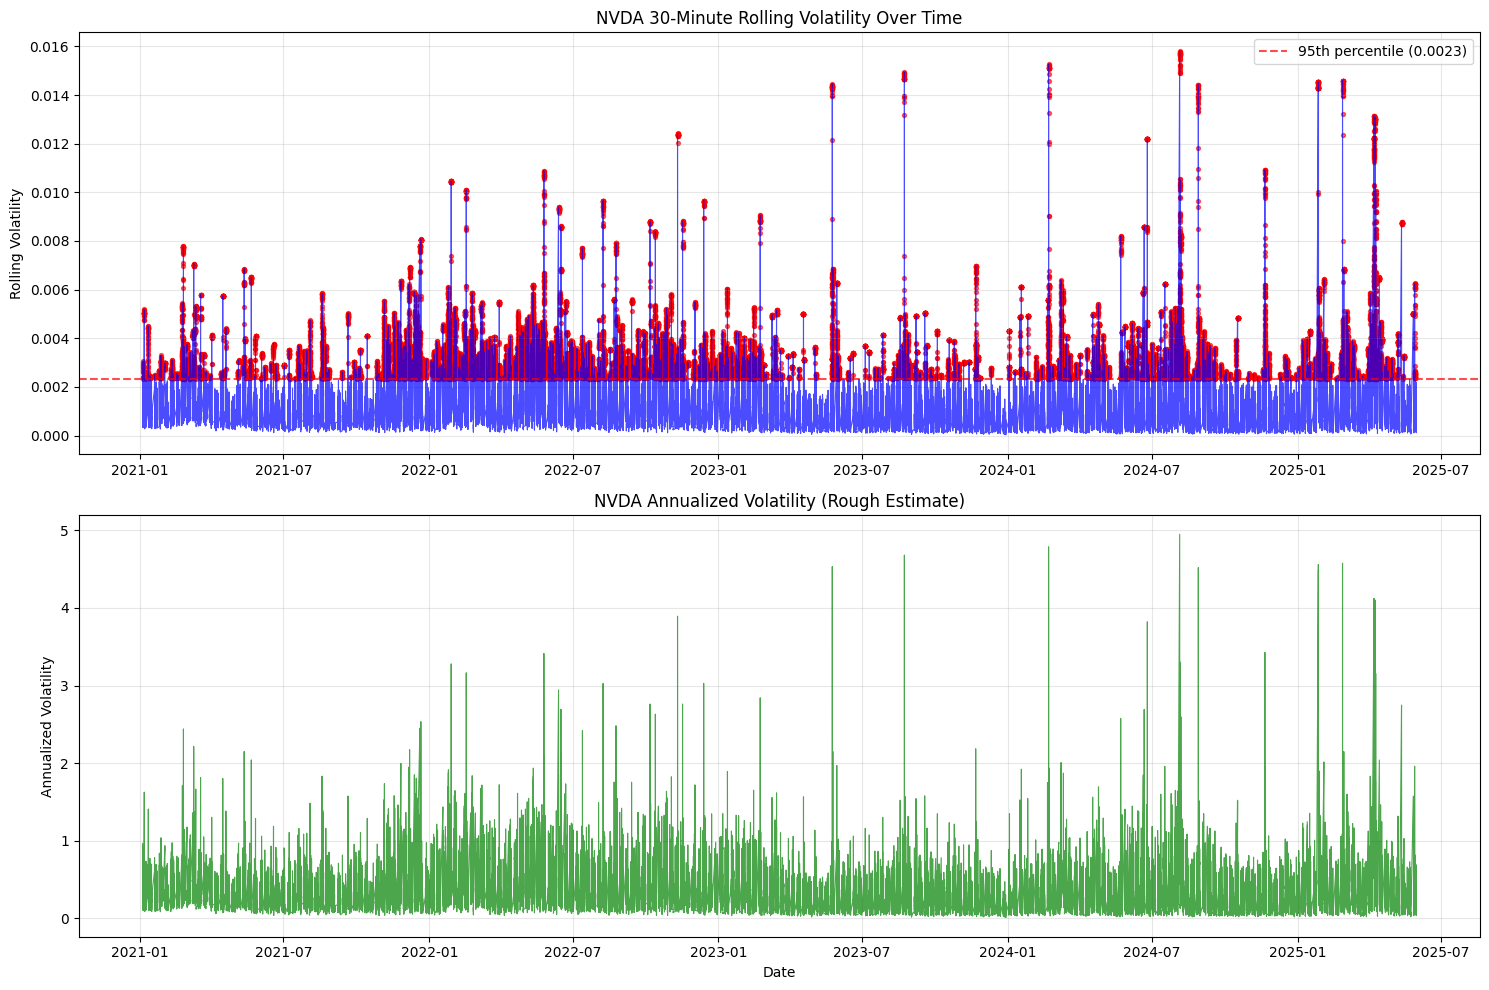

In [4]:
# Plot rolling volatility over time
plt.figure(figsize=(15, 10))

# Main volatility plot
plt.subplot(2, 1, 1)
plt.plot(rolling_vol.index, rolling_vol, linewidth=0.8, color='blue', alpha=0.7)
plt.axhline(y=high_vol_threshold, color='red', linestyle='--', alpha=0.7, 
           label=f'95th percentile ({high_vol_threshold:.4f})')
plt.scatter(high_vol_periods.index, high_vol_periods, color='red', s=8, alpha=0.6)
plt.title('NVDA 30-Minute Rolling Volatility Over Time')
plt.ylabel('Rolling Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

# Annualized volatility plot
plt.subplot(2, 1, 2)
plt.plot(rolling_vol_annual.index, rolling_vol_annual, linewidth=0.8, color='green', alpha=0.7)
plt.title('NVDA Annualized Volatility (Rough Estimate)')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Volatility Persistence Analysis

Test for volatility clustering using autocorrelation of squared returns.



=== VOLATILITY PERSISTENCE ===
Autocorrelation of squared returns (volatility clustering):
Lag 1: 0.1458
Lag 5: 0.0285
Lag 10: 0.0194
Lag 30: 0.0089
Lag 60: 0.0116


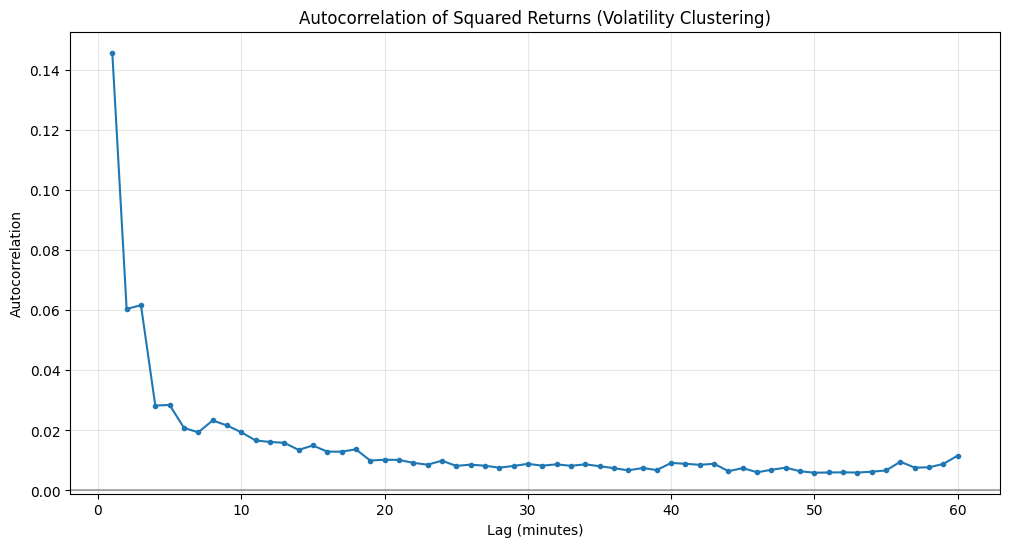


95% confidence interval for autocorrelation: ±0.0021
Statistically significant lags: [1, 5, 10, 30, 60]


In [5]:
print("\n=== VOLATILITY PERSISTENCE ===")
# Autocorrelation of squared returns (volatility clustering test)
squared_returns = returns_series ** 2
autocorr_lags = [1, 5, 10, 30, 60]  # 1min, 5min, 10min, 30min, 1hour

print("Autocorrelation of squared returns (volatility clustering):")
for lag in autocorr_lags:
    autocorr = squared_returns.autocorr(lag=lag)
    print(f"Lag {lag}: {autocorr:.4f}")

# Plot autocorrelation function
from statsmodels.tsa.stattools import acf
lags_extended = range(1, 61)  # 1 to 60 minutes
autocorr_values = [squared_returns.autocorr(lag=lag) for lag in lags_extended]

plt.figure(figsize=(12, 6))
plt.plot(lags_extended, autocorr_values, marker='o', markersize=3)
plt.title('Autocorrelation of Squared Returns (Volatility Clustering)')
plt.xlabel('Lag (minutes)')
plt.ylabel('Autocorrelation')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.show()

# Statistical significance test
n = len(squared_returns)
confidence_interval = 1.96 / np.sqrt(n)  # 95% confidence interval
print(f"\n95% confidence interval for autocorrelation: ±{confidence_interval:.4f}")
significant_lags = [lag for lag, autocorr in zip(autocorr_lags, [squared_returns.autocorr(lag=lag) for lag in autocorr_lags]) 
                   if abs(autocorr) > confidence_interval]
print(f"Statistically significant lags: {significant_lags}")
